# TrainFinalModel
Important: Use Python 3.8, not 3.10! Prophet is not compatible with 3.8 :(

In [2]:
import math
from datetime import datetime
from datetime import timedelta
import pandas as pd
from pathlib import Path
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.utilities import regressor_coefficients
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot as plt
from prophet.serialize import model_to_json, model_from_json
import math

### Settings

In [3]:
# https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Switzerland
COVID_START = datetime(2020, 3, 1).date()
# https://www.admin.ch/gov/en/start/documentation/media-releases.msg-id-84127.html
# date taken as the second easing of restrictions during 2021
COVID_END = datetime(2021, 6, 1).date()

MODEL_PATH = Path("../data/model/")
TRAIN_DATA_PATH = Path('../data/consumption/final_train.parquet')
DATA_PATH_2022 = Path('../data/consumption/2022.parquet')

MODEL_NAME = "totalconsumption_rolling7day.json"
CONSUMPTION_EXPR = "NE5Consumption + NE7Consumption" # i.e. "NE5Consumption + NE7Consumption", "NE5Consumption", "NE7Consumption"
ROLLING_WINDOW = 7
#CONFIDENCE_INTERVAL = 0.95
CONFIDENCE_INTERVAL = 0.99
USE_WEEK_SEASONALITY = False
USE_HOLIDAYS = False

### Prepare Data
* y = Energy Consumption Netzebene 5 & 7 (`NE5`, `NE7`)
* Regressors: `CosYearTemp` & `SinYearTemp`

In [5]:
train = pd.read_parquet(TRAIN_DATA_PATH, engine='pyarrow')
train['Date'] = pd.to_datetime(train['Date'])
train['y'] = train['NE5Consumption'] + train['NE7Consumption']
train['CosYearTemp'] = train.apply(lambda row: row['Temperature'] * math.cos(row['Date'].dayofyear * 2 * math.pi / 365), axis=1)
train['SinYearTemp'] = train.apply(lambda row: row['Temperature'] * math.sin(row['Date'].dayofyear * 2 * math.pi / 365), axis=1)
train.rename(columns={'Date': 'ds'}, inplace=True)
train = train.sort_values('ds')
train = train.rolling(window=ROLLING_WINDOW, on='ds').mean().dropna()#[:-ROLLING_WINDOW]
train.tail()

,ds,CosYearTemp,NE5Consumption,NE7Consumption,SinYearTemp,Temperature,y
4378,2021-12-27,2.820697,2.444119e+06,5.135075e+06,-0.248734,2.831548,7.579194e+06
4379,2021-12-28,3.958501,2.404289e+06,5.030473e+06,-0.317863,3.972024,7.434763e+06
4380,2021-12-29,5.408283,2.358133e+06,4.932551e+06,-0.398725,5.425595,7.290684e+06
4381,2021-12-30,6.992434,2.321458e+06,4.843913e+06,-0.404744,7.008333,7.165370e+06
4382,2021-12-31,7.580403,2.311679e+06,4.809497e+06,-0.327896,7.591667,7.121177e+06


In [4]:
# add covid as a one-off holiday
covid = pd.DataFrame([
    {'holiday': 'covid', 'ds': COVID_START, 'lower_window': 0, 'ds_upper': COVID_END}
])

covid['upper_window'] = (covid['ds_upper'] - covid['ds']).dt.days

### Fit Model

In [5]:
m = Prophet(
    holidays = covid, 
    weekly_seasonality = USE_WEEK_SEASONALITY,
    changepoint_prior_scale = 0.005,
    changepoint_range=1,
    interval_width=CONFIDENCE_INTERVAL,
    uncertainty_samples = 10000
)

if USE_HOLIDAYS:
    m.add_country_holidays(country_name='CH')
  
m.add_regressor("CosYearTemp", prior_scale = 0.05, standardize = True, mode = "additive")
m.add_regressor("SinYearTemp", prior_scale = 0.05, standardize = True, mode = "additive")

m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -11.7341
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         15270    0.00657831       7965.41           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       15330.5   0.000112701       763.492      0.5663      0.5663      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       15348.3    0.00688731       4987.96           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       15353.5   0.000529925        545.48      0.9925      0.9925      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       15354.1   4.35282e-06       648.839      0.4233      0.4233      598   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [6]:
# Store Model
with open(MODEL_PATH / MODEL_NAME, 'w') as fout:
    fout.write(model_to_json(m))

### Some stats...

In [7]:
forecastTrain = m.predict(train)

/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/for

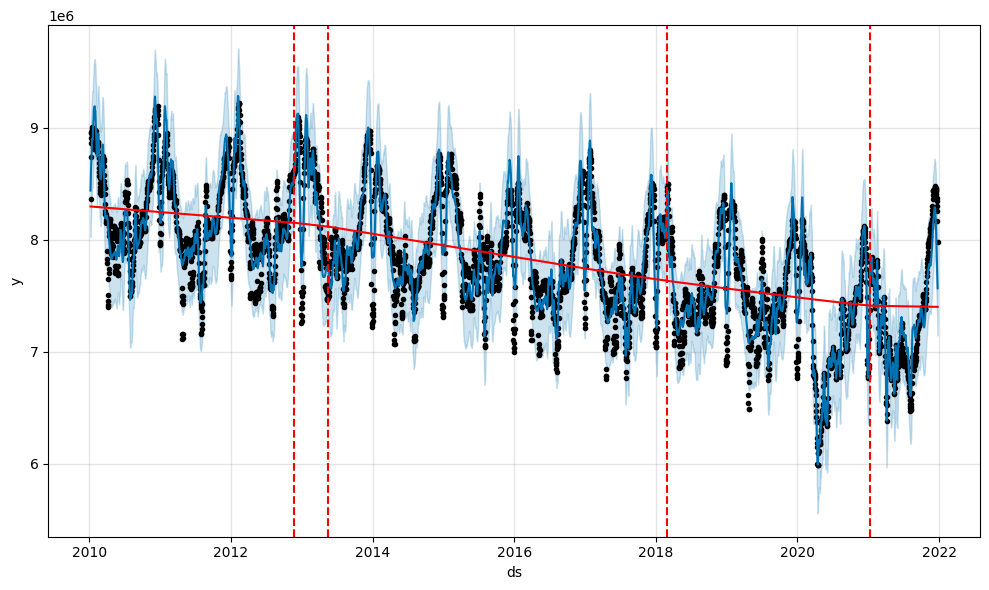

In [8]:
fig = m.plot(forecastTrain)
a = add_changepoints_to_plot(fig.gca(), m, forecastTrain)

In [9]:
mse = mean_squared_error(train["y"].to_numpy(), forecastTrain["yhat"].to_numpy())
mse

27298644527.564865

In [10]:
rmse = math.sqrt(mse)
rmse

165223.01452147902

In [11]:
mean_absolute_percentage_error(train["y"].to_numpy(), forecastTrain["yhat"].to_numpy())

0.015007961841507045

In [12]:
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,CosYearTemp,additive,-4.510686,-46687.244909,-46687.244909,-46687.244909
1,SinYearTemp,additive,-1.329717,-20799.399467,-20799.399467,-20799.399467


In [13]:
plotData = pd.DataFrame(
  {
    "Actual": train["y"].array,
    "PredictedMean": forecastTrain["yhat"].array,
    "PredictedHigh": forecastTrain["yhat_upper"].array,
    "PredictedLow": forecastTrain["yhat_lower"].array
  },
  index=train["ds"]
)

plotData.index = pd.to_datetime(plotData.index)
plotData = plotData.sort_index()

In [14]:
def plot(data):
  fig, ax = plt.subplots()
  fig.set_size_inches(12, 8)
  fig.patch.set_facecolor('white')
  ax.plot(data.index, data["Actual"])
  ax.fill_between(data.index, data["PredictedHigh"], data["PredictedLow"], color='orange', alpha=.2)

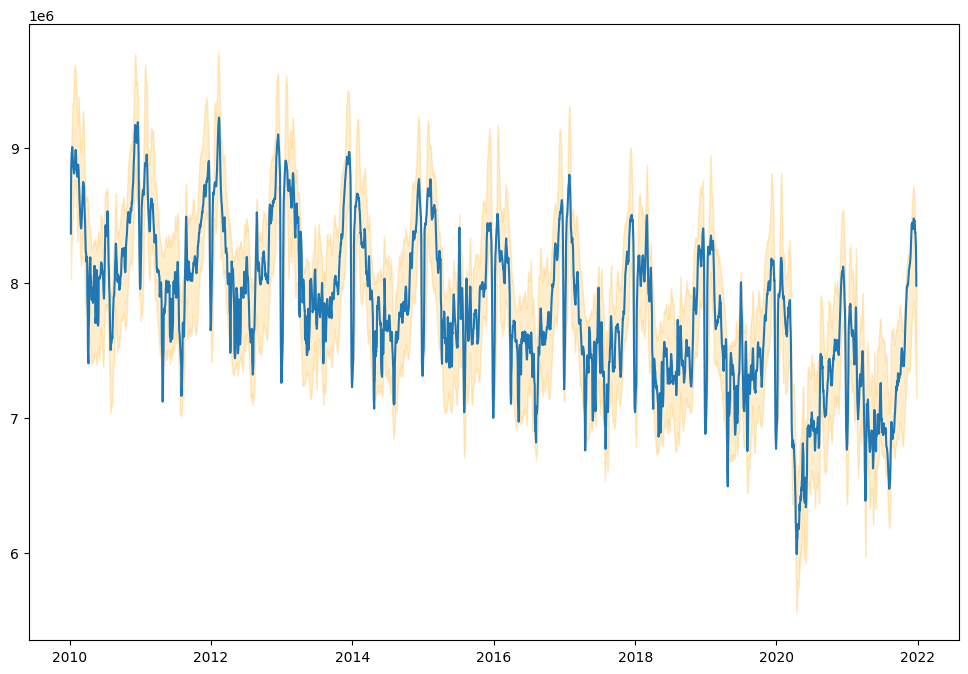

In [15]:
plot(plotData)

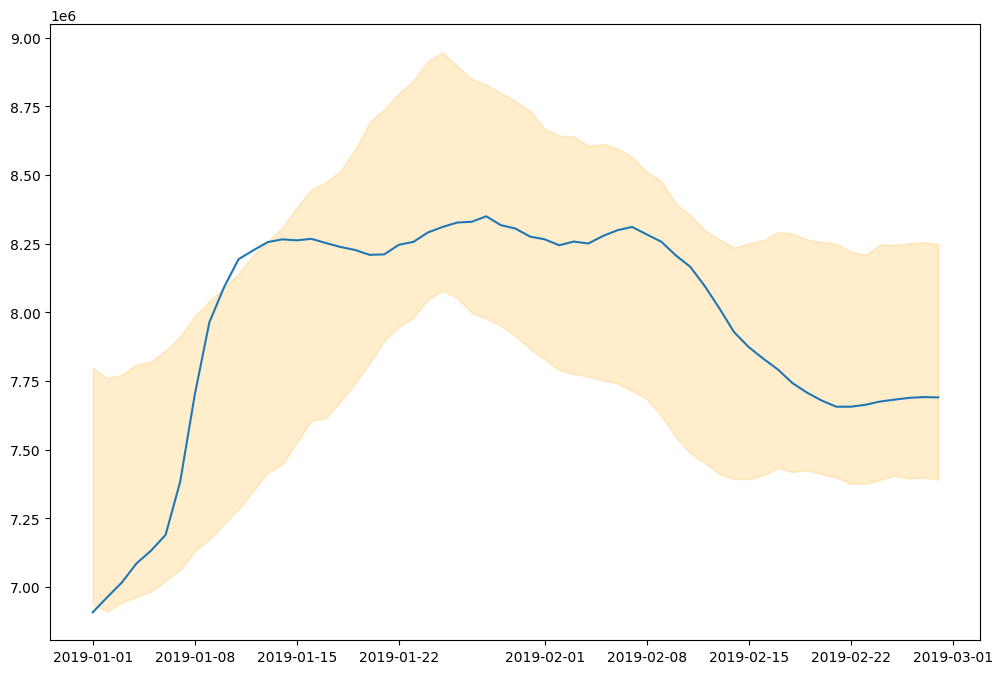

In [16]:
plot(plotData[(plotData.index >= datetime(2019, 1, 1)) & (plotData.index < datetime(2019, 3, 1))])

/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


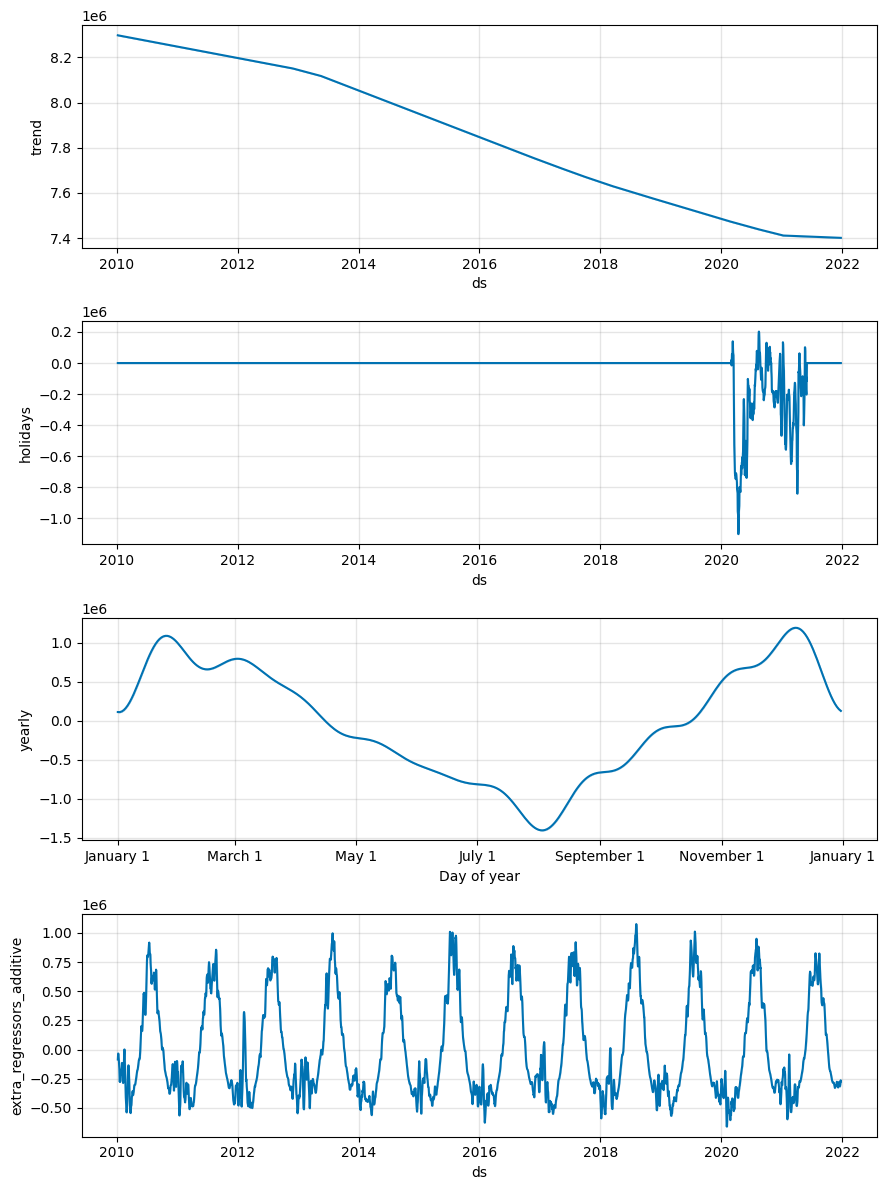

In [17]:
fig = m.plot_components(forecastTrain)

### Test Modell with 2022 data

In [18]:
df_2022 = pd.read_parquet(DATA_PATH_2022, engine='pyarrow')
df_2022['Date'] = pd.to_datetime(df_2022['Date'])
df_2022['y'] = df_2022['NE5Consumption'] + df_2022['NE7Consumption']

df_2022['CosYearTemp'] = df_2022.apply(lambda row: row['Temperature'] * math.cos(row['Date'].dayofyear * 2 * math.pi / 365), axis=1)
df_2022['SinYearTemp'] = df_2022.apply(lambda row: row['Temperature'] * math.sin(row['Date'].dayofyear * 2 * math.pi / 365), axis=1)

df_2022.rename(columns={'Date': 'ds'}, inplace=True)
df_2022 = df_2022.sort_values('ds')

df_2022 = df_2022.rolling(ROLLING_WINDOW, on='ds').mean().dropna()

forecastTrain = m.predict(df_2022)

/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/simon/Documents/projects/energyconsumption-zurich-model/env/lib/python3.8/site-packages/prophet/for

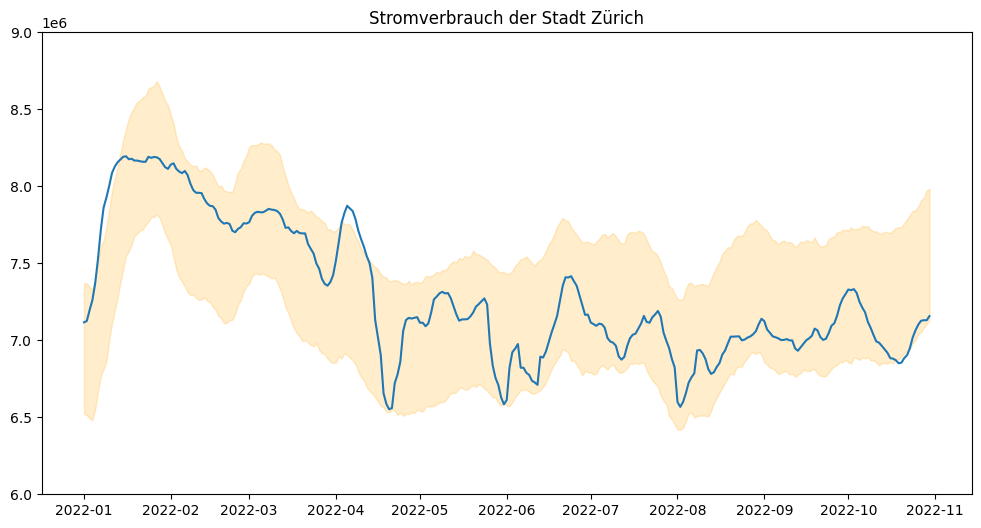

In [19]:
def plot(data):
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 6)
    fig.patch.set_facecolor('white')
    ax.set_title('Stromverbrauch der Stadt Zürich')
    ax.plot(data.index, data["Actual"])
    ax.fill_between(data.index, data["PredictedHigh"], data["PredictedLow"], color='orange', alpha=.2)
    ax.set_ylim(6e+06, 9e+06)

plotData = pd.DataFrame(
  {
    "Actual": df_2022["y"].array,
    "PredictedMean": forecastTrain["yhat"].array,
    "PredictedHigh": forecastTrain["yhat_upper"].array,
    "PredictedLow": forecastTrain["yhat_lower"].array
  },
  index=df_2022["ds"]
)

plotData.index = pd.to_datetime(plotData.index)
plotData = plotData.sort_index()

plot(plotData)

In [20]:
plotData = plotData.div(1000000).round(2)
plotData

,Actual,PredictedMean,PredictedHigh,PredictedLow
ds,,,,
2022-01-01,7.12,6.94,7.37,6.52
2022-01-02,7.13,6.95,7.37,6.51
2022-01-03,7.20,6.92,7.35,6.49
2022-01-04,7.26,6.90,7.33,6.48
2022-01-05,7.37,6.97,7.40,6.55
...,...,...,...,...
2022-10-26,7.10,7.46,7.87,7.04
2022-10-27,7.13,7.48,7.91,7.05
2022-10-28,7.13,7.51,7.92,7.08
